### Acknowledgements

In [362]:
import pandas as pd
import numpy as np
import plotly
import pycountry
import pycountry_convert as pc
import plotly_express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',2000,'display.max_columns',2000)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import geopy as geo
import seaborn as sns
import us

### Visualizations and insights on JHU Data

In [3]:
JHU_Global_CC_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\time_series_covid19_confirmed_global.csv')
JHU_US_CC_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\time_series_covid19_confirmed_US.csv')
JHU_Global_Death_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\time_series_covid19_deaths_global.csv')
JHU_US_Death_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\time_series_covid19_deaths_US.csv')
JHU_Global_Recov_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\time_series_covid19_recovered_global.csv')

In [109]:

def getABBR(statename):
    
    
    if statename in ( 'American Samoa','Diamond Princess','Grand Princess', 'Guam','Northern Mariana Islands','Virgin Islands'):
        return '0'
    
    try:
        state = us.states.lookup(statename)    
    except:
        return '0'
    
    if state == None:
        return '0'
    
    return state.abbr

def Restructure_df(df,new_columns):
    
    for x in range(df.shape[0]):
    
        temp = df.drop(labels = ['Province/State','Country/Region','Lat','Long'],axis = 1).iloc[x].reset_index()

        temp.columns = ['Date',new_columns]
        temp['Country/Region'] = (df.iloc[x]['Country/Region'])
        temp['Province/State'] = (df.iloc[x]['Province/State'])
        temp['Lat'] = (df.iloc[x]['Lat'])
        temp['Long'] = (df.iloc[x]['Long'])
        temp['Date'] = temp['Date'].astype(np.datetime64)
        if x == 0:
            covid_df = pd.DataFrame(data = temp)
        else:
            covid_df = covid_df.append(temp)
            
    covid_df = covid_df.groupby(by= ['Country/Region','Date'])[new_columns].sum().reset_index()
            
    count = 0
    for country in covid_df['Country/Region'].unique():
        count += 1
        Covid_country = covid_df[covid_df['Country/Region']==country].reset_index(drop = True)  
        Daily_stats = Covid_country[new_columns].diff()
        Daily_stats.loc[0] = Covid_country.iloc[0][new_columns]
        daily = 'Daily '+ new_columns
        Covid_country[daily] = Daily_stats
        if count == 1:
            covid_df_country = pd.DataFrame(data = Covid_country)
        else:
            covid_df_country = covid_df_country.append(Covid_country)    


    return covid_df_country.reset_index(drop = True)
    
    
def Restructure_USA_df(df,new_columns):
    
    for x in range(df.shape[0]):
    
        temp = df.drop(labels = ['UID','iso2','iso3','code3','FIPS','Admin2','Combined_Key','Province_State','Country_Region','Lat','Long_'],axis = 1).iloc[x].reset_index()

        temp.columns = ['Date',new_columns]
        #temp['Country_Region'] = (df.iloc[x]['Country_Region'])
        temp['Province_State'] = (df.iloc[x]['Province_State'])
        temp['Lat'] = (df.iloc[x]['Lat'])
        temp['Long_'] = (df.iloc[x]['Long_'])
        temp['iso2'] = (df.iloc[x]['iso2'])
        temp['iso3'] = (df.iloc[x]['iso3'])
        temp['Date'] = temp['Date'].astype(np.datetime64)
        if x == 0:
            covid_df = pd.DataFrame(data = temp)
        else:
            covid_df = covid_df.append(temp)
            
    covid_USA_df = covid_df.groupby(by= ['Province_State','Date'])[new_columns].sum().reset_index()
            
#     count = 0
#     for country in covid_df[['Lat','Long_']].unique():
#         count += 1
#         Covid_country = covid_df[covid_df['iso2']==country].reset_index(drop = True)  
#         Daily_stats = Covid_country[new_columns].diff()
#         Daily_stats.loc[0] = Covid_country.iloc[0][new_columns]
#         daily = 'Daily '+ new_columns
#         Covid_country[daily] = Daily_stats
#         if count == 1:
#             covid_df_country = pd.DataFrame(data = Covid_country)
#         else:
#             covid_df_country = covid_df_country.append(Covid_country)    


    return covid_USA_df.reset_index(drop = True)
    

In [5]:
class country_utils():
    def __init__(self):
        self.d = {}
    
    def get_dic(self):
        return self.d
    
    def get_country_details(self,country):
        """Returns country code(alpha_3) and continent"""
        try:
            country_obj = pycountry.countries.get(name=country)
            if country_obj is None:
                c = pycountry.countries.search_fuzzy(country)
                country_obj = c[0]
            continent_code = pc.country_alpha2_to_continent_code(country_obj.alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj.alpha_3, continent
        except:
            if 'Congo' in country:
                country = 'Congo'
            elif country == 'Diamond Princess' or country == 'Laos' or country == 'MS Zaandam'\
            or country == 'Holy See' or country == 'Timor-Leste':
                return country, country
            elif country == 'Korea, South' or country == 'South Korea':
                country = 'Korea, Republic of'
            elif country == 'Taiwan*':
                country = 'Taiwan'
            elif country == 'Burma':
                country = 'Myanmar'
            elif country == 'West Bank and Gaza':
                country = 'Gaza'
            else:
                return country, country
            country_obj = pycountry.countries.search_fuzzy(country)
            continent_code = pc.country_alpha2_to_continent_code(country_obj[0].alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj[0].alpha_3, continent
    
    def get_iso3(self, country):
        return self.d[country]['code']
    
    def get_continent(self,country):
        return self.d[country]['continent']
    
    def add_values(self,country):
        self.d[country] = {}
        self.d[country]['code'],self.d[country]['continent'] = self.get_country_details(country)
    
    def fetch_iso3(self,country):
        if country in self.d.keys():
            return self.get_iso3(country)
        else:
            self.add_values(country)
            return self.get_iso3(country)
        
    def fetch_continent(self,country):
        if country in self.d.keys():
            return self.get_continent(country)
        else:
            self.add_values(country)
            return self.get_continent(country)

In [6]:
Covid_ww_df_cc = Restructure_df(JHU_Global_CC_df,'Confirmed Cases')
Covid_ww_df_deaths = Restructure_df(JHU_Global_Death_df,'Deaths')
Covid_ww_df_recovered = Restructure_df(JHU_Global_Recov_df,'Recovered')

#merge the data
temp = pd.merge(Covid_ww_df_cc, Covid_ww_df_deaths, how='inner', on=['Country/Region','Date'])
Covid_country_df = pd.merge(temp,Covid_ww_df_recovered,how = 'inner',on = ['Country/Region','Date'])


## <a id='eda'>Worldwide Patterns</a>

In [390]:
Covid_country_sum_df = Covid_country_df[Covid_country_df['Date']==max(Covid_country_df['Date'])].sort_values(by = 'Confirmed Cases',ascending = False).reset_index()
Covid_country_sum_df['iso_alpha'] = Covid_country_sum_df['Country/Region'].apply(lambda x:country_utils().fetch_iso3(x))

df = Covid_country_sum_df
fig = px.scatter_geo(df, locations="iso_alpha", color="Confirmed Cases",
                     size="Confirmed Cases", title = 'Worldwide Distribution Of Confirmed Cases',
                     opacity=0.7, size_max=45,projection="natural earth")

fig.show()

### Insights
- Although the virus originated in Asia, Europe and North Amercia have the highest number of confirmed cases
- Africa seems relatively untouched, atleast for now
- Australia and New Zealand are doing good and so are many nations in South East Asia

In [10]:
df_tm = Covid_country_df.copy()
date = df_tm.Date.max()#get current date
df_tm = df_tm[df_tm['Date']==date]
obj = country_utils()
df_tm['continent'] = df_tm.apply(lambda x: obj.fetch_continent(x['Country/Region']), axis=1)
df_tm["world"] = "World" 
fig = px.treemap(df_tm, path=['world', 'continent', 'Country/Region'], values='Confirmed Cases',
                  color='Confirmed Cases', hover_data=['Country/Region'],
                  color_continuous_scale='dense', title='Current share of Worldwide COVID19 Confirmed Cases')
fig.show()

In [11]:
fig = px.treemap(df_tm, path=['world', 'continent', 'Country/Region'], values='Deaths',
                  color='Deaths', hover_data=['Country/Region'],
                  color_continuous_scale='matter', title='Current share of Worldwide COVID19 Deaths')
fig.show()

In [12]:
Covid_ww_df_cc_world = Covid_ww_df_cc.groupby(by = 'Date')['Confirmed Cases','Daily Confirmed Cases'].sum().reset_index()
Covid_ww_df_deaths_world = Covid_ww_df_deaths.groupby(by = 'Date')['Deaths','Daily Deaths'].sum().reset_index()
Covid_ww_df_recovered_world = Covid_ww_df_recovered.groupby(by = 'Date')['Recovered','Daily Recovered'].sum().reset_index()
temp = pd.merge(Covid_ww_df_cc_world, Covid_ww_df_deaths_world, how='inner', on='Date')
Covid_world_df = pd.merge(temp,Covid_ww_df_recovered_world,how = 'inner',on = 'Date')

#daily confirmed cases % change
Covid_world_df['Daily ConfirmedCase % Change'] = np.round(Covid_world_df['Daily Confirmed Cases'].pct_change()*100,2)
Covid_world_df['Daily ConfirmedCase % Change'].fillna(value = 0,inplace = True)

#daily fatalities % change
Covid_world_df['Daily Fatalities % Change'] = np.round(Covid_world_df['Daily Deaths'].pct_change()*100,2)
Covid_world_df['Daily Fatalities % Change'].fillna(value = 0,inplace = True)

#find the fatalities as percentage of total Confirmed Cases
Covid_world_df['Cumulative Death Percentage'] = (Covid_world_df['Deaths']/Covid_world_df['Confirmed Cases'])*100
Covid_world_df['Daily Death Percentage'] = (Covid_world_df['Daily Deaths']/Covid_world_df['Daily Confirmed Cases'])*100

#find the fatalities as percentage of total Confirmed Cases
Covid_world_df['Cumulative Recovered Percentage'] = (Covid_world_df['Recovered']/Covid_world_df['Confirmed Cases'])*100
Covid_world_df['Daily Recovered Percentage'] = (Covid_world_df['Daily Recovered']/Covid_world_df['Daily Confirmed Cases'])*100


#rolling averages
Covid_world_df['CC Rolling average'] = Covid_world_df['Daily Confirmed Cases'].rolling(7).mean()
Covid_world_df['F Rolling average'] = Covid_world_df['Daily Deaths'].rolling(7).mean()

Covid_world_df.fillna(value = 0,inplace = True)

In [13]:
fig = go.Figure(data=[go.Bar(name='Cases', x=Covid_world_df['Date'], y= Covid_world_df['Daily Confirmed Cases']),
    go.Bar(name='Deaths', x=Covid_world_df['Date'], y=Covid_world_df['Daily Deaths'])])

fig.add_trace(go.Scatter(name='Confirmed Cases Rolling average',x=Covid_world_df['Date'],y=Covid_world_df['CC Rolling average'],marker_color='yellow'))
fig.add_trace(go.Scatter(name='Fatalities Rolling average',x=Covid_world_df['Date'],y=Covid_world_df['F Rolling average'],marker_color='green'))

fig.update_layout(barmode = 'overlay',title='Worldwide Daily Cases + Deaths and 7 Day Rolling Averages',showlegend=True)
fig.show()

In [14]:
fig = go.Figure(data=[go.Scatter(name='Fatalities %', x=Covid_world_df['Date'], y=Covid_world_df['Cumulative Death Percentage'],marker=dict(color='red')),
                go.Scatter(name='Recovered %', x=Covid_world_df['Date'], y=Covid_world_df['Cumulative Recovered Percentage'],marker=dict(color='blue'))])

fig.update_layout(title='Worldwide Cumulative Death % and Recovered % Curve',showlegend=True,width=950, height=400)
fig.show()


### Insights
- Worldwide confirmed cases showing an upward trend in May after staying stagnant for much of the April
- Worldwide Cumulative Death percentage seems to be flattening at around 6%
- Worldwide Recovery percentage is around 35%, this means that at any given time, around 65% of the cases still remain active 

## <a id='eda'>Country Specific Patterns </a>

### A quick look at USA

In [ ]:
USA_cc_df = Restructure_USA_df(JHU_US_CC_df,'ConfirmedCases')

In [204]:
USA_pop_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\US_Population.csv')
USA_df = USA_cc_df[USA_cc_df['Date'] == max(USA_cc_df['Date'])]
USA_df['State_iso'] = USA_df['Province_State'].apply(lambda x:getABBR(x))
USA_pop_df['State_iso'] = USA_pop_df['State'].apply(lambda x:getABBR(x))
USA_df = USA_df[USA_df['State_iso'] != '0'].reset_index(drop = True)
USA_pop_df = USA_pop_df[USA_pop_df['State_iso'] != '0'].reset_index(drop = True)
USA_merged_df = USA_pop_df.merge(USA_df,on = 'State_iso')
USA_merged_df['ConfirmedCases Per Million'] = (USA_merged_df['ConfirmedCases']/USA_merged_df['Pop'])*100000

In [293]:
df = USA_pop_df

fig1 = go.Figure(go.Choropleth(locations = USA_merged_df['State_iso'],text=USA_merged_df['State_iso'],colorbar_title = "Confirmed Cases",colorscale = 'ylorbr',locationmode="USA-states", z=USA_merged_df['ConfirmedCases']))

fig1.update_layout(
    title_text = 'Distribution of Confirmed Cases in USA',
    geo_scope='usa', geo = dict(resolution = 110))

fig2 = go.Figure(go.Choropleth(locations=USA_merged_df['State_iso'],z = USA_merged_df['Pop'],locationmode = 'USA-states', colorscale = 'ylorbr',colorbar_title = "Population in Millions"))

fig2.update_layout(
    title_text = 'US Population Distribution',
    geo_scope='usa',legend_orientation="h")

fig2.show()
fig1.show()


In [391]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=USA_merged_df['Province_State'],
    y=USA_merged_df['density'],
    name='Population Density',
    marker_color='green',mode = 'markers+lines'
))
fig.add_trace(go.Scatter(
    x=USA_merged_df['Province_State'],
    y=USA_merged_df['ConfirmedCases Per Million'],
    name='ConfirmedCases Per Million',
    marker_color='red',mode = 'markers+lines'
))

fig.update_layout(title_text = 'Population density vs Confirmed Cases Per Million in US States',barmode='group', xaxis_tickangle=-45,width = 1200,height = 400,legend_orientation="h",legend=dict(x=.01, y=1.2))
fig.show()

### Insights
- Infection density is matching very closely with population density in almost all of the states, underlying the need of social distancing in population areas
- Eastern and Western seaboards have far greater infection rates when compared to mid-west and central USA

In [392]:
Covid_country_sum_df['Case %'] = (Covid_country_sum_df['Confirmed Cases']/Covid_country_sum_df['Confirmed Cases'].sum())*100
Covid_country_sum_df['Death %'] = (Covid_country_sum_df['Deaths']/Covid_country_sum_df['Deaths'].sum())*100

Top_10_cc = Covid_country_sum_df[0:10]['Country/Region']
Top_10_deaths = Covid_country_sum_df.sort_values(by = 'Deaths',ascending=False)[0:10]['Country/Region']

Top_10_cc_df = Covid_country_df.groupby(by = ['Country/Region','Date'])['Confirmed Cases'].sum().reset_index()
Top_10_cc_df = Top_10_cc_df[Top_10_cc_df['Country/Region'].isin(Top_10_cc)].reset_index()

Top_10_deaths_df = Covid_country_df.groupby(by = ['Country/Region','Date'])['Deaths'].sum().reset_index()
Top_10_deaths_df = Top_10_deaths_df[Top_10_deaths_df['Country/Region'].isin(Top_10_deaths)].reset_index()


In [393]:
Covid_country_sum_df= Covid_country_sum_df[0:10]

fig = go.Figure()
fig.add_trace(
    go.Bar(x=Covid_country_sum_df['Country/Region'], y=Covid_country_sum_df['Case %'],name = 'Confirmed Case %',marker_color='indianred'))

fig.add_trace(
    go.Bar(x=Covid_country_sum_df['Country/Region'], y=Covid_country_sum_df['Death %'],name = 'Fatalities %',marker_color='lightsalmon'))

fig.update_layout(barmode='group', xaxis_tickangle=-45,title_text = 'Worldwide Distribution of Cases and Fatalities in Top 10')
fig.show()


In [380]:
fig = px.line(data_frame=Top_10_cc_df, x='Date', log_y = True, y='Confirmed Cases', color='Country/Region',title = 'Confirmed Cases in Log Scale in Top 10 Countries')
fig.update_layout(height=400, width=1100,legend_orientation="h",legend=dict(x=.01, y=1.15),legend_title_text='')
fig.show()

In [381]:
fig = px.line(data_frame=Top_10_deaths_df, x='Date', y='Deaths', color='Country/Region',title = 'Fatalities in Log Scale in Top 10 Countries')
fig.update_layout(height=400, width=1100,legend_orientation="h",legend=dict(x=.01, y=1.15),legend_title_text='')
fig.show()

### Insights
- US is basically at a different level !
- US accounts for 45% of confirmed cases and 35% of the fatalities worldwide
- Russia accounts for 8% of confirmed cases but only about 1% of fatalities
- UK, Italy, France and Spain have considerably larger share of fatalities than confirmed cases (probably due to much older population ? )
- The rate of infection in US seems to be stablizing but the fatalities are still climbing too steeply
- Turkey has it first case on 11th March and then saw a very rapid growth, entering top 10 very quickly
- Russia and Brazil are other two countries which are seeing a rapid growth 



# Analysis on the risk factors for COVID-19

## Climatic Factors

### 1) Temperature

In [430]:
merged_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\covid19-country-data\covid19_merged.csv')
merged_df['iso'] = merged_df['country'].apply(lambda x:country_utils().fetch_iso3(x))

In [521]:
merged_df = merged_df[merged_df['annual_temp'].notnull()].reset_index(drop = True)
master_df = Covid_country_df_iso.merge(merged_df,on = 'iso')
master_df.drop_duplicates(subset = 'iso',inplace = True)
master_df.sort_values(by = 'Confirmed Cases',inplace = True,ascending=False)
fig = px.scatter(data_frame=master_df, x='annual_temp', y='Confirmed Cases',size = 'Confirmed Cases',color = 'Country/Region',size_max = 80,title = 'Country Confirmed Cases vs Average Temperature')
fig.update_layout(autosize=False,width=1100,height=500,xaxis_title="Average Annual Temperature in Celsius Degree")

fig.show()

In [524]:
master_df['Per Million Cases'] = (master_df['Confirmed Cases']/master_df['Population_2020'])*1000000
master_df['Per Million Deaths'] = (master_df['Deaths']/master_df['Population_2020'])*1000000
master_df = master_df[master_df['Per Million Cases'].notnull()].reset_index(drop = True)
master_temp_df = master_df[master_df['Population_2020'] > 1000000]

In [525]:
fig = px.scatter(data_frame=master_temp_df, x='annual_temp', y='Per Million Cases',size = 'Per Million Cases',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Average Annual Temperature')
fig.update_layout(autosize=False,width=1100,height=500,xaxis_title = 'Average Annual Temperature in Celsius Degree')
fig.show()

### 2) Precipitation

In [526]:
fig = px.scatter(data_frame=master_df, x='Annual_precip', y='Per Million Cases',size = 'Per Million Cases',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Annual Precipitation')
fig.update_layout(autosize=False,width=1100,height=500,xaxis_title = 'Annual Precipitation in mm')
fig.show()

### Insights
- Countries having rainfall range between (0-1500) and a temperate climate are more susceptible to COVID infections
- As we move towards hot and humid climate, the infection/million rate starts falling (Qatar being the outlier), can this be one of the reasons why Africa is doing good ? 
- High temperature and high humidity seem detrimental to the growth of the infection

## Demographic Factors

### 1) Urban Population

In [531]:
master_df = master_df[master_df['Urban_pop_pct'] != 'N.A.']
master_df['Urban_pop_pct'] = master_df['Urban_pop_pct'].apply(lambda x:int(str(x).replace('%','')))

In [532]:
master_df['Urban_pop_pct_bins'] = pd.cut(master_df['Urban_pop_pct'],6,include_lowest=True,precision=0)

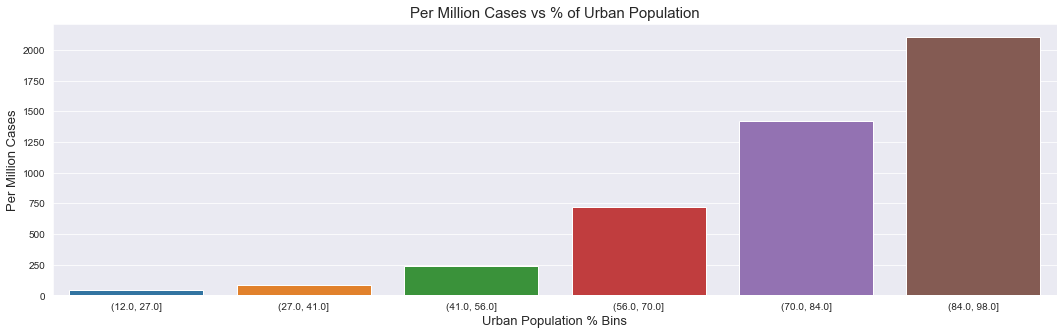

In [535]:

Urban_pop_df = master_df.groupby(by = 'Urban_pop_pct_bins')['Per Million Cases'].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (18,5))
sns.barplot(Urban_pop_df['Urban_pop_pct_bins'],Urban_pop_df['Per Million Cases'],ax = ax1)
sns.set_style(style = 'darkgrid')
plt.xlabel('Urban Population % Bins',fontsize=13)
plt.ylabel('Per Million Cases',fontsize=13)
plt.title('Per Million Cases vs % of Urban Population',fontsize=15)
plt.show()

In [536]:
fig = px.scatter(data_frame=master_df, x='Urban_pop_pct', y='Per Million Cases',size = 'Per Million Cases',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Urban Population')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title="Urban Population %")
fig.show()

### Insights
- Urbanization seems to have a strong correlaton with the infection rates, this probably is due to the fact that people in urban areas tend to socialize and move a lot when compared to rural areas

### Age

In [541]:
fig = px.scatter(data_frame=master_df, x='Median_age', y='Per Million Cases',size = 'Per Million Cases',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Median Age')
fig.update_layout(autosize=False,width=1100,height=500)
fig.show()

## Growth of Infections vs Air Traffic

In [545]:
master_df[master_df['iso']=='USA']

NameError: name 'country_merged_df' is not defined

In [547]:
fig = px.scatter(data_frame=master_df, x='airport_traffic_2018_thousands', y='Per Million Cases',size = 'Per Million Cases',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Average Annual Temperature')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title="Urban Population %")
fig.show()

### Affect of Lockdown

In [549]:
lockdown_df = pd.read_csv(r'C:\Users\tyagik\Jupyter Sandbox Folder\Kaggle\COVID-19 Week 5\covid19-lockdown-dates-by-country\countryLockdowndatesJHUMatch.csv')

In [550]:
lockdown_df['iso'] = lockdown_df['Country/Region'].apply(lambda x:country_utils().fetch_iso3(x))
lockdown_df

,Country/Region,Date,Type,Reference,iso
0,Mainland China,2020-01-23,Full,https://en.wikipedia.org/wiki/2019%E2%80%9320_...,Mainland China
1,Hong Kong,2020-03-23,Full,https://en.wikipedia.org/wiki/2020_coronavirus...,HKG
2,Macau,2020-01-26,Full,https://en.wikipedia.org/wiki/2020_coronavirus...,Macau
3,Taiwan,2020-02-02,Full,https://en.wikipedia.org/wiki/2020_coronavirus...,TWN
4,US,2020-03-23,Partial,https://en.wikipedia.org/wiki/2020_coronavirus...,USA
5,Japan,2020-02-27,Full,https://en.wikipedia.org/wiki/2020_coronavirus...,JPN
6,Thailand,2020-03-22,Partial,https://en.wikipedia.org/wiki/2020_coronavirus...,THA
7,South Korea,2020-02-23,Full,https://en.wikipedia.org/wiki/2020_coronavirus...,KOR
8,Singapore,2020-03-26,Partial,https://en.wikipedia.org/wiki/2020_coronavirus...,SGP
9,Philippines,2020-03-16,Partial,https://en.wikipedia.org/wiki/2020_coronavirus...,PHL


In [554]:
fig = px.line(data_frame=Top_10_cc_df, x=Top_10_cc_df['Date'], y=Top_10_cc_df['Confirmed Cases'], line_group='Country/Region', color='Country/Region')
fig.update_layout(showlegend=False,annotations=[dict(x='2020-01-23',xref="x",yref="y",text="dict Text",showarrow=True,arrowhead=7,ax=0,ay=-40)])
fig.show()

### ICU Beds vs Deaths Per Million

In [548]:
fig = px.scatter(data_frame=master_df,size = 'Per Million Deaths', size_max = 80,x = 'hosp_beds_per_1000_2017', y='Per Million Deaths',color = 'Country/Region',title = 'Cases Per Million Population vs Average Annual Temperature')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title="Urban Population %")
fig.show()
#x = 'Health_Care_Index'
#x = ICU-CCB_beds_per_100000